In [ ]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data Viz
import cufflinks as cf

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Enviroment setup
cf.go_offline()
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Lectura de los datos están en un archivo CSV llamado ''
df = pd.read_csv('/content/drive/MyDrive/Temas/train_deliveries.csv')

# Exploración inicial
print(df.head())
print(df.info())
print(df.describe())

             pickup_datetime  pickup_longitude  pickup_latitude  \
0  2009-01-01 01:15:22+00:00          -73.9819          40.7795   
1  2009-01-01 01:59:17+00:00          -73.9838          40.7214   
2  2009-01-01 02:05:03+00:00          -73.9566          40.7713   
3  2009-01-01 02:09:13+00:00          -73.9846          40.7280   
4  2009-01-01 02:13:41+00:00          -73.9801          40.7374   

   dropoff_longitude  dropoff_latitude  product_count      region  \
0           -73.9577           40.7710              2  Commercial   
1           -73.9948           40.6872              2   Residence   
2           -73.9915           40.7498              2      Others   
3           -73.9557           40.7768              1      Others   
4           -74.0095           40.7260              4   Residence   

   delivery_fee  
0        8.5000  
1       13.0000  
2       10.6000  
3       12.2000  
4       11.0000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198959 entries, 0 to 198

In [ ]:
#Limpieza de datos

# Verificar valores faltantes
missing_values = df.isnull().sum()
print(missing_values)

# Opcional: rellenar o eliminar valores faltantes
df = df.dropna()  # Eliminamos filas con valores faltantes


pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
product_count        0
region               0
delivery_fee         0
dtype: int64


In [ ]:
# Verificar duplicados
duplicates = df.duplicated().sum()
print(f'Number of duplicates: {duplicates}')

# Eliminar duplicados
df = df.drop_duplicates()



Number of duplicates: 0


In [ ]:
#Transformacion de datos
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
#Crear Nuevas Columnas para el Análisis de Series Temporales
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday


Analisis Descriptivo

In [ ]:
#codificar Variables Categóricas
df = pd.get_dummies(df, columns=['region'])


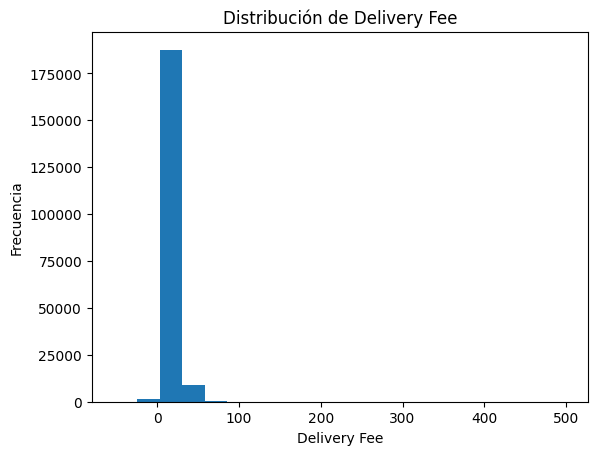

In [ ]:
#Visualizar la distribución de las tarifas de entrega.
import matplotlib.pyplot as plt

plt.hist(df['delivery_fee'], bins=20)
plt.title('Distribución de Delivery Fee')
plt.xlabel('Delivery Fee')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
#Tabla Analítica para Predicción de delivery_fee
# Selección de características
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'product_count', 'year', 'month', 'day', 'hour', 'weekday'] + list(df.columns[df.columns.str.startswith('region_')])
target = 'delivery_fee'

# Creación de la tabla analítica
analytical_table = df[features + [target]]

print(analytical_table.head())


   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          -73.9819          40.7795           -73.9577           40.7710   
1          -73.9838          40.7214           -73.9948           40.6872   
2          -73.9566          40.7713           -73.9915           40.7498   
3          -73.9846          40.7280           -73.9557           40.7768   
4          -73.9801          40.7374           -74.0095           40.7260   

   product_count  year  month  day  hour  weekday  region_Commercial  \
0              2  2009      1    1     1        3               True   
1              2  2009      1    1     1        3              False   
2              2  2009      1    1     2        3              False   
3              1  2009      1    1     2        3              False   
4              4  2009      1    1     2        3              False   

   region_Manufacturing  region_Others  region_Residence  delivery_fee  
0                 False        

In [ ]:
#Tabla Analítica para Predicción de product_count

# Selección de características (pueden ser las mismas o diferentes)
features_for_product_count = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'weekday'] + list(df.columns[df.columns.str.startswith('region_')])
target_for_product_count = 'product_count'

# Creación de la tabla analítica
analytical_table_product_count = df[features_for_product_count + [target_for_product_count]]

print(analytical_table_product_count.head())


   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          -73.9819          40.7795           -73.9577           40.7710   
1          -73.9838          40.7214           -73.9948           40.6872   
2          -73.9566          40.7713           -73.9915           40.7498   
3          -73.9846          40.7280           -73.9557           40.7768   
4          -73.9801          40.7374           -74.0095           40.7260   

   year  month  day  hour  weekday  region_Commercial  region_Manufacturing  \
0  2009      1    1     1        3               True                 False   
1  2009      1    1     1        3              False                 False   
2  2009      1    1     2        3              False                 False   
3  2009      1    1     2        3              False                 False   
4  2009      1    1     2        3              False                 False   

   region_Others  region_Residence  product_count  
0         

In [ ]:
# Carga de datos
df = pd.read_csv('/content/drive/MyDrive/Temas/train_deliveries.csv')

# Exploración inicial
print(df.head())
print(df.info())
print(df.describe())

# Limpieza de datos
df = df.dropna()
df = df.drop_duplicates()

# Transformación de datos
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday

# Codificación de variables categóricas
df = pd.get_dummies(df, columns=['region'])

# Generación de tabla analítica para predicción de delivery_fee
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'product_count', 'year', 'month', 'day', 'hour', 'weekday'] + list(df.columns[df.columns.str.startswith('region_')])
target = 'delivery_fee'
analytical_table = df[features + [target]]
print(analytical_table.head())

# Generación de tabla analítica para predicción de product_count
features_for_product_count = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'weekday'] + list(df.columns[df.columns.str.startswith('region_')])
target_for_product_count = 'product_count'
analytical_table_product_count = df[features_for_product_count + [target_for_product_count]]
print(analytical_table_product_count.head())



             pickup_datetime  pickup_longitude  pickup_latitude  \
0  2009-01-01 01:15:22+00:00          -73.9819          40.7795   
1  2009-01-01 01:59:17+00:00          -73.9838          40.7214   
2  2009-01-01 02:05:03+00:00          -73.9566          40.7713   
3  2009-01-01 02:09:13+00:00          -73.9846          40.7280   
4  2009-01-01 02:13:41+00:00          -73.9801          40.7374   

   dropoff_longitude  dropoff_latitude  product_count      region  \
0           -73.9577           40.7710              2  Commercial   
1           -73.9948           40.6872              2   Residence   
2           -73.9915           40.7498              2      Others   
3           -73.9557           40.7768              1      Others   
4           -74.0095           40.7260              4   Residence   

   delivery_fee  
0        8.5000  
1       13.0000  
2       10.6000  
3       12.2000  
4       11.0000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198959 entries, 0 to 198

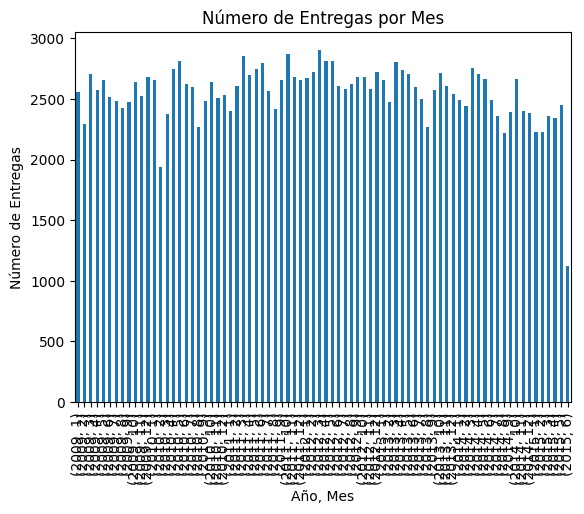

In [ ]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month

deliveries_per_month = df.groupby(['year', 'month']).size()
deliveries_per_month.plot(kind='bar')
plt.title('Número de Entregas por Mes')
plt.xlabel('Año, Mes')
plt.ylabel('Número de Entregas')
plt.show()


In [ ]:
# Cargar los datos los datos están en un archivo CSV llamado 'deliveries.csv'
df = pd.read_csv('/content/drive/MyDrive/Temas/train_deliveries.csv')

# Convertir la columna pickup_datetime a tipo datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Crear una nueva columna para la fecha (sin la hora)
df['date'] = df['pickup_datetime'].dt.date

# Contar el número de entregas por día
daily_deliveries = df.groupby('date').size().reset_index(name='deliveries')

# Convertir la columna 'date' de nuevo a tipo datetime
daily_deliveries['date'] = pd.to_datetime(daily_deliveries['date'])

print(daily_deliveries.head())


        date  deliveries
0 2009-01-01          63
1 2009-01-02          60
2 2009-01-03          84
3 2009-01-04          75
4 2009-01-05          64


In [ ]:
# Crear características temporales
daily_deliveries['year'] = daily_deliveries['date'].dt.year
daily_deliveries['month'] = daily_deliveries['date'].dt.month
daily_deliveries['day'] = daily_deliveries['date'].dt.day
daily_deliveries['weekday'] = daily_deliveries['date'].dt.weekday

print(daily_deliveries.head())


        date  deliveries  year  month  day  weekday
0 2009-01-01          63  2009      1    1        3
1 2009-01-02          60  2009      1    2        4
2 2009-01-03          84  2009      1    3        5
3 2009-01-04          75  2009      1    4        6
4 2009-01-05          64  2009      1    5        0


In [ ]:
from sklearn.model_selection import train_test_split

# Definir características (features) y el objetivo (target)
features = ['year', 'month', 'day', 'weekday']
target = 'deliveries'

# Dividir los datos en conjuntos de entrenamiento y prueba
X = daily_deliveries[features]
y = daily_deliveries[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)


(1885, 4) (472, 4)


In [ ]:
#Entrenar el modelo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')


MAE: 11.368994114669805
MSE: 213.5634138518974
RMSE: 14.613809012434007


In [ ]:
#Realizar prediccion

import numpy as np
from datetime import datetime, timedelta

# Crear un DataFrame con las próximas 15 fechas
future_dates = pd.date_range(start=daily_deliveries['date'].max() + timedelta(days=1), periods=15)

# Crear un DataFrame con las características temporales de las próximas 15 fechas
future_data = pd.DataFrame({
    'date': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'weekday': future_dates.weekday
})

# Predecir las entregas
future_features = future_data[features]
future_predictions = model.predict(future_features)

# Añadir las predicciones al DataFrame future_data
future_data['predicted_deliveries'] = future_predictions


print(future_data)


         date  year  month  day  weekday  predicted_deliveries
0  2015-06-16  2015      6   16        1               80.9204
1  2015-06-17  2015      6   17        2               82.0150
2  2015-06-18  2015      6   18        3               83.1095
3  2015-06-19  2015      6   19        4               84.2040
4  2015-06-20  2015      6   20        5               85.2986
5  2015-06-21  2015      6   21        6               86.3931
6  2015-06-22  2015      6   22        0               79.7695
7  2015-06-23  2015      6   23        1               80.8640
8  2015-06-24  2015      6   24        2               81.9586
9  2015-06-25  2015      6   25        3               83.0531
10 2015-06-26  2015      6   26        4               84.1477
11 2015-06-27  2015      6   27        5               85.2422
12 2015-06-28  2015      6   28        6               86.3367
13 2015-06-29  2015      6   29        0               79.7131
14 2015-06-30  2015      6   30        1               

In [ ]:
#2do modelo

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime, timedelta

# Carga de datos
df = pd.read_csv('/content/drive/MyDrive/Temas/train_deliveries.csv')

# Convertir pickup_datetime a tipo datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Filtrar los datos para la región "Commercial"
df_commercial = df[df['region'] == 'Commercial']

# Crear columna de fecha sin hora
df_commercial['date'] = df_commercial['pickup_datetime'].dt.date

# Contar entregas por día
daily_commercial_deliveries = df_commercial.groupby('date').size().reset_index(name='deliveries')
daily_commercial_deliveries['date'] = pd.to_datetime(daily_commercial_deliveries['date'])

# Calcular el promedio histórico de entregas
average_deliveries = daily_commercial_deliveries['deliveries'].mean()
print(f'Promedio histórico de entregas: {average_deliveries}')

# Crear características temporales y etiquetas
daily_commercial_deliveries['year'] = daily_commercial_deliveries['date'].dt.year
daily_commercial_deliveries['month'] = daily_commercial_deliveries['date'].dt.month
daily_commercial_deliveries['day'] = daily_commercial_deliveries['date'].dt.day
daily_commercial_deliveries['weekday'] = daily_commercial_deliveries['date'].dt.weekday
daily_commercial_deliveries['above_average'] = (daily_commercial_deliveries['deliveries'] > average_deliveries).astype(int)

# Definir características y etiquetas
features = ['year', 'month', 'day', 'weekday']
target = 'above_average'

X = daily_commercial_deliveries[features]
y = daily_commercial_deliveries[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Predecir si las entregas superarán el promedio histórico para los próximos 15 días
future_dates = pd.date_range(start=daily_commercial_deliveries['date'].max() + timedelta(days=1), periods=15)
future_data = pd.DataFrame({
    'date': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'weekday': future_dates.weekday
})
future_features = future_data[features]
future_predictions = model.predict(future_features)
future_data['above_average_predicted'] = future_predictions

print(future_data)


Promedio histórico de entregas: 21.185405176071278
Accuracy: 0.5317796610169492
[[154 114]
 [107  97]]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       268
           1       0.46      0.48      0.47       204

    accuracy                           0.53       472
   macro avg       0.52      0.53      0.52       472
weighted avg       0.53      0.53      0.53       472

         date  year  month  day  weekday  above_average_predicted
0  2015-06-16  2015      6   16        1                        0
1  2015-06-17  2015      6   17        2                        0
2  2015-06-18  2015      6   18        3                        0
3  2015-06-19  2015      6   19        4                        1
4  2015-06-20  2015      6   20        5                        1
5  2015-06-21  2015      6   21        6                        1
6  2015-06-22  2015      6   22        0                        0
7  2015-06-23  2015      6   23        1  